# Description

Cab mobility traces are provided by the museum of science, art and human perception through the cabspotting project:
http://cabspotting.org

Each San Francisco based Yellow Cab vehicle is currently outfitted with a GPS tracking device that is used by dispatchers to
efficiently reach customers. The data is transmitted from each cab to a central receiving station, and then delivered in 
real-time to dispatch computers via a central server. This system broadcasts the cab call number, location and whether the 
cab currently has a fare.

You can use this data set of cab mobility traces that were. This archive contains file '_cabs.txt' with the list of all cabs
and for each cab its mobility trace in a separate ASCII file, e.g. 'new_abboip.txt'. The format of each mobility trace file is
the following - each line contains [latitude, longitude, occupancy, time], e.g.: [37.75134 -122.39488 0 1213084687], where 
latitude and longitude are in decimal degrees, occupancy shows if a cab has a fare (1 = occupied, 0 = free) and time.

In [1]:
# Importar as bibliotecas

import numpy as np
import pandas as pd
import seaborn as sns

import time
from datetime import datetime
import geopy.distance

import random

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
%matplotlib inline

## Input data about Yellow Cabs 

In [2]:
# Ler o arquivo CSV 

df_Cab = pd.read_csv('new_abboip.csv')   

In [3]:
# Exibir o cabeçalho do dataframe

df_Cab.head()

,37.75134 -122.39488 0 1213084687
0,37.75136 -122.39527 0 1213084659
1,37.75199 -122.3946 0 1213084540
2,37.7508 -122.39346 0 1213084489
3,37.75015 -122.39256 0 1213084237
4,37.75454 -122.39227 0 1213084177


In [4]:
# Verificar as dimensões do dataframe

df_Cab.shape

(23494, 1)

In [5]:
# Separar as colunas do dataframe

df_Cab = df_Cab['37.75134 -122.39488 0 1213084687'].str.split(' ', expand=True)

In [6]:
df_Cab.head()

,0,1,2,3
0,37.75136,-122.39527,0,1213084659
1,37.75199,-122.3946,0,1213084540
2,37.7508,-122.39346,0,1213084489
3,37.75015,-122.39256,0,1213084237
4,37.75454,-122.39227,0,1213084177


In [7]:
# Verificar as dimensões do dataframe

df_Cab.shape

(23494, 4)

In [8]:
# Renomear as colunas do dataframe

df_Cab.columns = ['latitude','longitude','occupancy', 'time']  

#occupancy (1 for passengers, 0 for empty)

In [9]:
# Exibir o cabeçalho do dataframe

df_Cab.head()

,latitude,longitude,occupancy,time
0,37.75136,-122.39527,0,1213084659
1,37.75199,-122.3946,0,1213084540
2,37.7508,-122.39346,0,1213084489
3,37.75015,-122.39256,0,1213084237
4,37.75454,-122.39227,0,1213084177


In [10]:
# Verificar os tipos de dados do dataframe

df_Cab.dtypes

latitude     object
longitude    object
occupancy    object
time         object
dtype: object

In [11]:
# Converter as colunas 'latitude' e 'longitude' para float

df_Cab['latitude'] = df_Cab['latitude'].astype(float)
df_Cab['longitude'] = df_Cab['longitude'].astype(float)

In [12]:
# Converter a coluna 'occupancy' para int

df_Cab['occupancy'] = df_Cab['occupancy'].astype(int)

In [13]:
# Converter a coluna 'time' (object/UNIX para datetime)
    
df_Cab['time'] = pd.to_datetime(df_Cab['time'],unit='s')

In [14]:
# Verificar os tipos de dados do dataframe

df_Cab.dtypes

latitude            float64
longitude           float64
occupancy             int32
time         datetime64[ns]
dtype: object

## Questions about the Data

We can think about some interesting questions about this apparently simple data.

In [15]:
# Exibir o cabeçalho do dataframe 

df_Cab

,latitude,longitude,occupancy,time
0,37.75136,-122.39527,0,2008-06-10 07:57:39
1,37.75199,-122.39460,0,2008-06-10 07:55:40
2,37.75080,-122.39346,0,2008-06-10 07:54:49
3,37.75015,-122.39256,0,2008-06-10 07:50:37
4,37.75454,-122.39227,0,2008-06-10 07:49:37
5,37.75901,-122.39250,0,2008-06-10 07:49:32
6,37.77053,-122.39788,0,2008-06-10 07:48:12
7,37.77669,-122.39382,0,2008-06-10 07:47:12
8,37.78194,-122.38844,0,2008-06-10 07:46:11
9,37.78999,-122.38909,0,2008-06-10 07:45:10


### Question 1) What is the temporal coverage of the data?

In [16]:
data_init = df_Cab['time'].min()
data_end = df_Cab['time'].max()

print("The temporal coverate is:", data_end - data_init)

The temporal coverate is: 23 days 17:45:29


### Question 2) What is its spatial coverage?

In [17]:
coords_1 = (df_Cab['latitude'].min(), df_Cab['longitude'].min())
coords_2 = (df_Cab['latitude'].max(), df_Cab['longitude'].max())

print("The spatial coverage is {} Km" .format(geopy.distance.vincenty(coords_1, coords_2).km))

The spatial coverage is 57.71130786026215 Km


C:\Users\Usuario\Anaconda3\envs\cap394\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning:

Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.



### Question 3) What does the data looks like over a map?

In [18]:
from mpl_toolkits.basemap import Basemap

C:\Users\Usuario\Anaconda3\envs\cap394\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning:


The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.



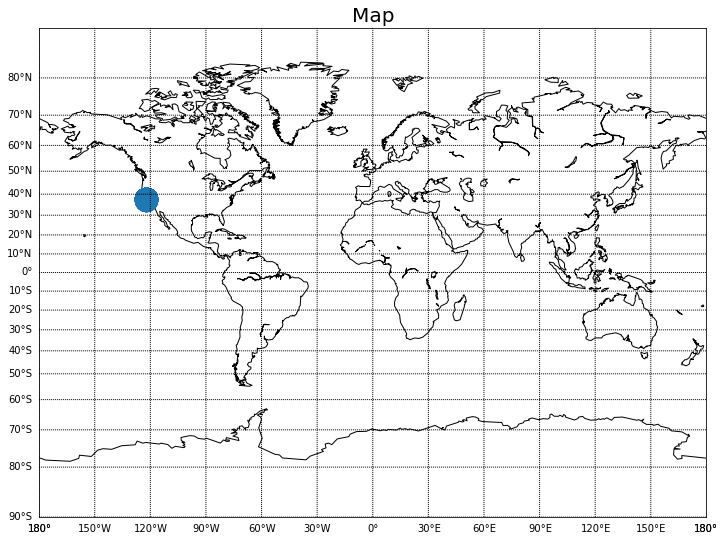

In [19]:
fig = plt.figure(figsize=(12,9))

m = Basemap(projection ='mill',
           llcrnrlat   = -90,
           urcrnrlat   = 90,
           llcrnrlon   = -180,
           urcrnrlon   = 180,
           resolution  = 'c')

#San Francisco: Latitude: 37.7272, Longitude: -123.032 37° 43′ 38″ Norte, 123° 1′ 55″ Oeste

m.drawcoastlines()

m.drawparallels(np.arange(-90,90,10), labels = [True,False,False,False])
m.drawmeridians(np.arange(-180,180,30), labels = [0,0,0,1])

sites_lat_y = df_Cab['latitude'].tolist()
sites_lon_x = df_Cab['longitude'].tolist()

m.scatter(sites_lon_x, sites_lat_y,latlon=True, s=500, marker='o', alpha=1, linewidth=1, zorder=2)

plt.title('Map', fontsize=20)

plt.show()

### Question 4) Who is the busiest cab?

In [20]:
# Precisaria analisar mais de um dataframa (este dataframe se refere a apenas um táxi)

### Question 5) How many distinct rides we have (considering a ride a continuous sequence of records with occupancy)?

In [21]:
cont = 0

for i in range(0, len(df_Cab)):

    if(df_Cab['occupancy'].iloc[i] == 1):
        cont += 1

print("We have {} distinct rides." .format(cont))

We have 9854 distinct rides.


### Question 6) What are the shortest and longest rides (with simplified distance, i.e. considering straight lines between records)? How is the distribution of the rides' lenght?

### Question 7) What are the shortest and longest rides in time?

In [22]:
# Array para armazenar as datas que o táxi estava ocupado 
array_date = [] 

# Percorrer a coluna ''occupancy' do dataframe
for i in range(0, len(df_Cab)):    
    
    if(df_Cab['occupancy'].iloc[i] == 1):
        
        # Adiciona a data no array 
        array_date.append(df_Cab['time'].iloc[i])  

### $\color{blue}{\text{Função para detectar a data/hora inicial do passeio.}}$ 

In [23]:
def func_init_concentrations(array_date):   
    
    array_date_init_concentrations = []
    
    dates = sorted(array_date)
    
    concentrations = [[dates[0]]]                                  

    for date in dates[1:]:                                         # iterate through the rest of the dates
        last_date = concentrations[-1][-1]                         # look at the last date we added
        if (date - last_date) <= pd.Timedelta('0 days 00:05:00'):  # is it close enough to be in the same group?
            concentrations[-1].append(date)                        # if so, then put it in the same group
        else:                                                      # otherwise,
            concentrations.append([date])                          # make a new group with it at the head
                      
    for i in range(0, len(concentrations)):

        if(len(concentrations[i]) > 0):
            array_date_init_concentrations.append(concentrations[i][0])
    
    return(array_date_init_concentrations)

In [24]:
array_date_init_concentrations = func_init_concentrations(array_date)

### $\color{blue}{\text{Função para detectar a data/hora final do passeio.}}$ 

In [25]:
def func_end_concentrations(array_date):   
    
    array_date_init_concentrations = []
    
    dates = sorted(array_date)
    
    concentrations = [[dates[0]]]                     

    for date in dates[1:]:                               # iterate through the rest of the dates
        last_date = concentrations[-1][-1]               # look at the last date we added
        if (date - last_date) <= pd.Timedelta('0 days 00:05:00'):  # is it close enough to be in the same group?
            concentrations[-1].append(date)              # if so, then put it in the same group
        else:                                            # otherwise,
            concentrations.append([date])                # make a new group with it at the head
                     
    for i in range(0, len(concentrations)):

        if(len(concentrations[i]) > 0):
            tam = len(concentrations[i])
            array_date_init_concentrations.append(concentrations[i][tam-1])
    
    return(array_date_init_concentrations) 

In [26]:
array_date_end_concentrations = func_end_concentrations(array_date)

In [27]:
len(array_date_init_concentrations)

607

In [28]:
len(array_date_end_concentrations)

607

In [29]:
array_time_ride = []

for i in range(0, len(array_date_end_concentrations)):
    
    time_ride = array_date_end_concentrations[i]  -  array_date_init_concentrations[i] 
    
    # Desconsiderar passeios menores de 10 min
    if(time_ride > pd.to_timedelta('0 days 00:10:00')):
       array_time_ride.append(time_ride)

In [30]:
print("Shortest rides is:", min(array_time_ride))
print("Longest rides is:", max(array_time_ride))

Shortest rides is: 0 days 00:10:01
Longest rides is: 0 days 01:40:16


### Question 8) Can we identify offline intervals for the cabs?

In [31]:
# Array para armazenar as datas que o táxi estava off
array_date_off = [] 

# Percorrer a coluna ''occupancy' do dataframe
for i in range(0, len(df_Cab)):    
    
    if(df_Cab['occupancy'].iloc[i] == 0):
        
        # Adiciona a data no array 
        array_date_off.append(df_Cab['time'].iloc[i])

# Exibir o array de datas em que o táxi estava desocupado
array_date_off  

[Timestamp('2008-06-10 07:57:39'),
 Timestamp('2008-06-10 07:55:40'),
 Timestamp('2008-06-10 07:54:49'),
 Timestamp('2008-06-10 07:50:37'),
 Timestamp('2008-06-10 07:49:37'),
 Timestamp('2008-06-10 07:49:32'),
 Timestamp('2008-06-10 07:48:12'),
 Timestamp('2008-06-10 07:47:12'),
 Timestamp('2008-06-10 07:46:11'),
 Timestamp('2008-06-10 07:45:10'),
 Timestamp('2008-06-10 07:44:15'),
 Timestamp('2008-06-10 07:43:31'),
 Timestamp('2008-06-10 07:42:16'),
 Timestamp('2008-06-10 07:36:24'),
 Timestamp('2008-06-10 07:35:23'),
 Timestamp('2008-06-10 07:34:23'),
 Timestamp('2008-06-10 07:33:23'),
 Timestamp('2008-06-10 07:32:27'),
 Timestamp('2008-06-10 07:31:23'),
 Timestamp('2008-06-10 07:30:23'),
 Timestamp('2008-06-10 07:29:31'),
 Timestamp('2008-06-10 07:28:37'),
 Timestamp('2008-06-10 07:27:28'),
 Timestamp('2008-06-10 07:26:23'),
 Timestamp('2008-06-10 07:25:23'),
 Timestamp('2008-06-10 07:24:23'),
 Timestamp('2008-06-10 07:23:22'),
 Timestamp('2008-06-10 07:23:21'),
 Timestamp('2008-06-

### Question 9) How's the distribution of the length of the rides considering the hour of the day?

### Question 10) How's the distribution of the length of the rides considering the day of the week?

### Question 11) What is the longest time without a ride, for any cab (longest continuous sequence of records without occupancy)?

### Question 12) Can we find slow spots (e.g. where estimated speed is slow)?

### Question 13) Does the slow spots vary during the hours of the day?

### Question 14) Are there circular rides (i.e. rides where the starting and ending point are very close)?

### Question 15) Are there hotspots for passenger pickup, i.e. spots where the average length of the ride is larger than other spots nearby?

### Question 16) Can we predict length (distance) of ride based on time of day, day of week and pickup region?

Please note that not all these questions may be answerable: there is no guarantee that it is possible to answer all those questions without using additional data, which is not provided, or even with additional data. Even if the data is reliable we cannot be absolutely sure about some possible answers (e.g. feasability of identifying circular rides).